In [ ]:
# Installed this library for this needed later to show model summary
!pip install torchsummary

**Cài đặt thư viện và các APIs**

In [ ]:
import gc, os, cv2, PIL
import torchvision as tv
import torch.nn as nn
import torchsummary as ts
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import random
import torch
from torchvision import utils as tv_utils

**Kết nối Driver**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**In ra các nhãn đươc thiết lập (Sử dụng 15 nhãn đầu tiên cho mô hình)**

In [ ]:
labels_df = pd.read_csv('/content/drive/MyDrive/dataset/abc_dataset/labels.csv')
labels_df

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


**Xử lý dữ liệu**



In [ ]:
import os
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from collections import Counter
from sklearn.model_selection import train_test_split # Thêm import này
import torch # Giả sử bạn đang dùng PyTorch

# --- PHẦN 1: TẢI VÀ CHỌN NGẪU NHIÊN ẢNH ---
data_dir = '/content/drive/MyDrive/dataset/abc_dataset/myData'
all_images = []

for folder in range(15):
    folder_path = os.path.join(data_dir, str(folder))
    if not os.path.isdir(folder_path):
        continue

    for img in os.listdir(folder_path):
        if img.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, img)
            all_images.append((img_path, folder))

print("Tổng số ảnh trước khi lấy mẫu ngẫu nhiên:", len(all_images))

if len(all_images) < 3000:
    print(f"Cảnh báo: Không đủ ảnh ({len(all_images)}) để lấy mẫu 3000. Lấy tất cả ảnh có sẵn.")
    sample_images = all_images
else:
    sample_images = random.sample(all_images, 3000)

sample_labels = [label for _, label in sample_images]
label_counts = Counter(sample_labels)
print("Số lượng ảnh theo từng nhãn sau khi random:")
for label in sorted(label_counts):
    print(f"Nhãn {label}: {label_counts[label]} ảnh")

# --- PHẦN 2: TIỀN XỬ LÝ ẢNH VÀ CHUYỂN ĐỔI SANG TENSOR/NUMPY ARRAY ---
transform = transforms.Compose([
    transforms.ToTensor() # Chuyển PIL Image sang Tensor [C, H, W] trong khoảng [0, 1]
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Có thể thêm normalize nếu cần
])

x_list = [] # Lưu trữ các tensor ảnh
y_list = [] # Lưu trữ các nhãn

print("\nĐang tải và tiền xử lý ảnh...")
for img_path, label in sample_images:
    try:
        image = Image.open(img_path).convert("RGB") # Đảm bảo ảnh 3 kênh màu
        image_tensor = transform(image)
        x_list.append(image_tensor)
        y_list.append(label)
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {img_path}: {e}")
        continue

print(f"Đã tải và xử lý {len(x_list)} ảnh.")
print(f"Số lượng nhãn tương ứng: {len(y_list)}")

# Chuyển đổi list of tensors sang một tensor lớn hoặc numpy array
# Nếu bạn dùng PyTorch:
X = torch.stack(x_list) # X sẽ có shape (N, C, H, W)
y = torch.tensor(y_list) # y sẽ có shape (N,)

# Nếu bạn dùng Scikit-learn (cho train_test_split):
# X_np = X.numpy() # Chuyển tensor X sang numpy array
# y_np = y.numpy() # Chuyển tensor y sang numpy array

# --- PHẦN 3: CHIA TẬP DỮ LIỆU ---
# Đảm bảo X và y không rỗng sau khi tiền xử lý
if len(X) == 0:
    print("Lỗi: Không có ảnh nào được tải hoặc xử lý. Không thể chia tập dữ liệu.")
else:
    # Bước 1: chia train_val (85%) và test (15%)
    # Sử dụng X và y đã được chuyển đổi thành numpy array (hoặc tensor nếu train_test_split hỗ trợ trực tiếp)
    # Nếu X, y là torch tensors, hãy chuyển về numpy nếu sklearn.model_selection.train_test_split cần numpy
    # X_np, y_np = X.numpy(), y.numpy() # Nếu bạn quyết định dùng numpy cho sklearn

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.15, stratify=y, random_state=42
    )
    print(f"Kích thước X_train_val: {X_train_val.shape}")
    print(f"Kích thước X_test: {X_test.shape}")

    # Bước 2: chia train (70%) và val (15%) từ train_val (85%)
    val_size = 0.15 / 0.85 # Tỷ lệ validation trên tập train_val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42
    )
    print(f"Kích thước X_train: {X_train.shape}")
    print(f"Kích thước X_val: {X_val.shape}")

    # Giải phóng bộ nhớ (không bắt buộc với các biến nhỏ)
    import gc
    del X_train_val, y_train_val # Giữ X, y nếu cần sau này
    gc.collect()

    print(f"Kích thước y_train: {y_train.shape}")
    print(f"Kích thước y_val: {y_val.shape}")
    print(f"Kích thước y_test: {y_test.shape}")

    # --- PHẦN 4: ĐỊNH NGHĨA VÀ HUẤN LUYỆN MODEL (VÍ DỤ CHO PYTORCH) ---
    # Nếu bạn dùng PyTorch, bạn sẽ cần tạo Dataset và DataLoader
    # from torch.utils.data import TensorDataset, DataLoader
    # train_dataset = TensorDataset(X_train, y_train)
    # val_dataset = TensorDataset(X_val, y_val)
    # test_dataset = TensorDataset(X_test, y_test)

    # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # ... (Tiếp theo là định nghĩa model, loss function, optimizer, và vòng lặp huấn luyện) ...


Tổng số ảnh trước khi lấy mẫu ngẫu nhiên: 42721
Số lượng ảnh theo từng nhãn sau khi random:
Nhãn 0: 32 ảnh
Nhãn 1: 362 ảnh
Nhãn 2: 191 ảnh
Nhãn 3: 206 ảnh
Nhãn 4: 277 ảnh
Nhãn 5: 275 ảnh
Nhãn 6: 61 ảnh
Nhãn 7: 185 ảnh
Nhãn 8: 146 ảnh
Nhãn 9: 158 ảnh
Nhãn 10: 265 ảnh
Nhãn 11: 167 ảnh
Nhãn 12: 283 ảnh
Nhãn 13: 283 ảnh
Nhãn 14: 109 ảnh

Đang tải và tiền xử lý ảnh...
Đã tải và xử lý 3000 ảnh.
Số lượng nhãn tương ứng: 3000
Kích thước X_train_val: torch.Size([2550, 3, 32, 32])
Kích thước X_test: torch.Size([450, 3, 32, 32])
Kích thước X_train: torch.Size([2099, 3, 32, 32])
Kích thước X_val: torch.Size([451, 3, 32, 32])
Kích thước y_train: torch.Size([2099])
Kích thước y_val: torch.Size([451])
Kích thước y_test: torch.Size([450])


 **In ra 100 ảnh ngẫu nhiên trong tập Train**

<ipython-input-23-430329767>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(tv_utils.make_grid(torch.tensor(X_train[:100]),nrow=10).permute(1,2,0))


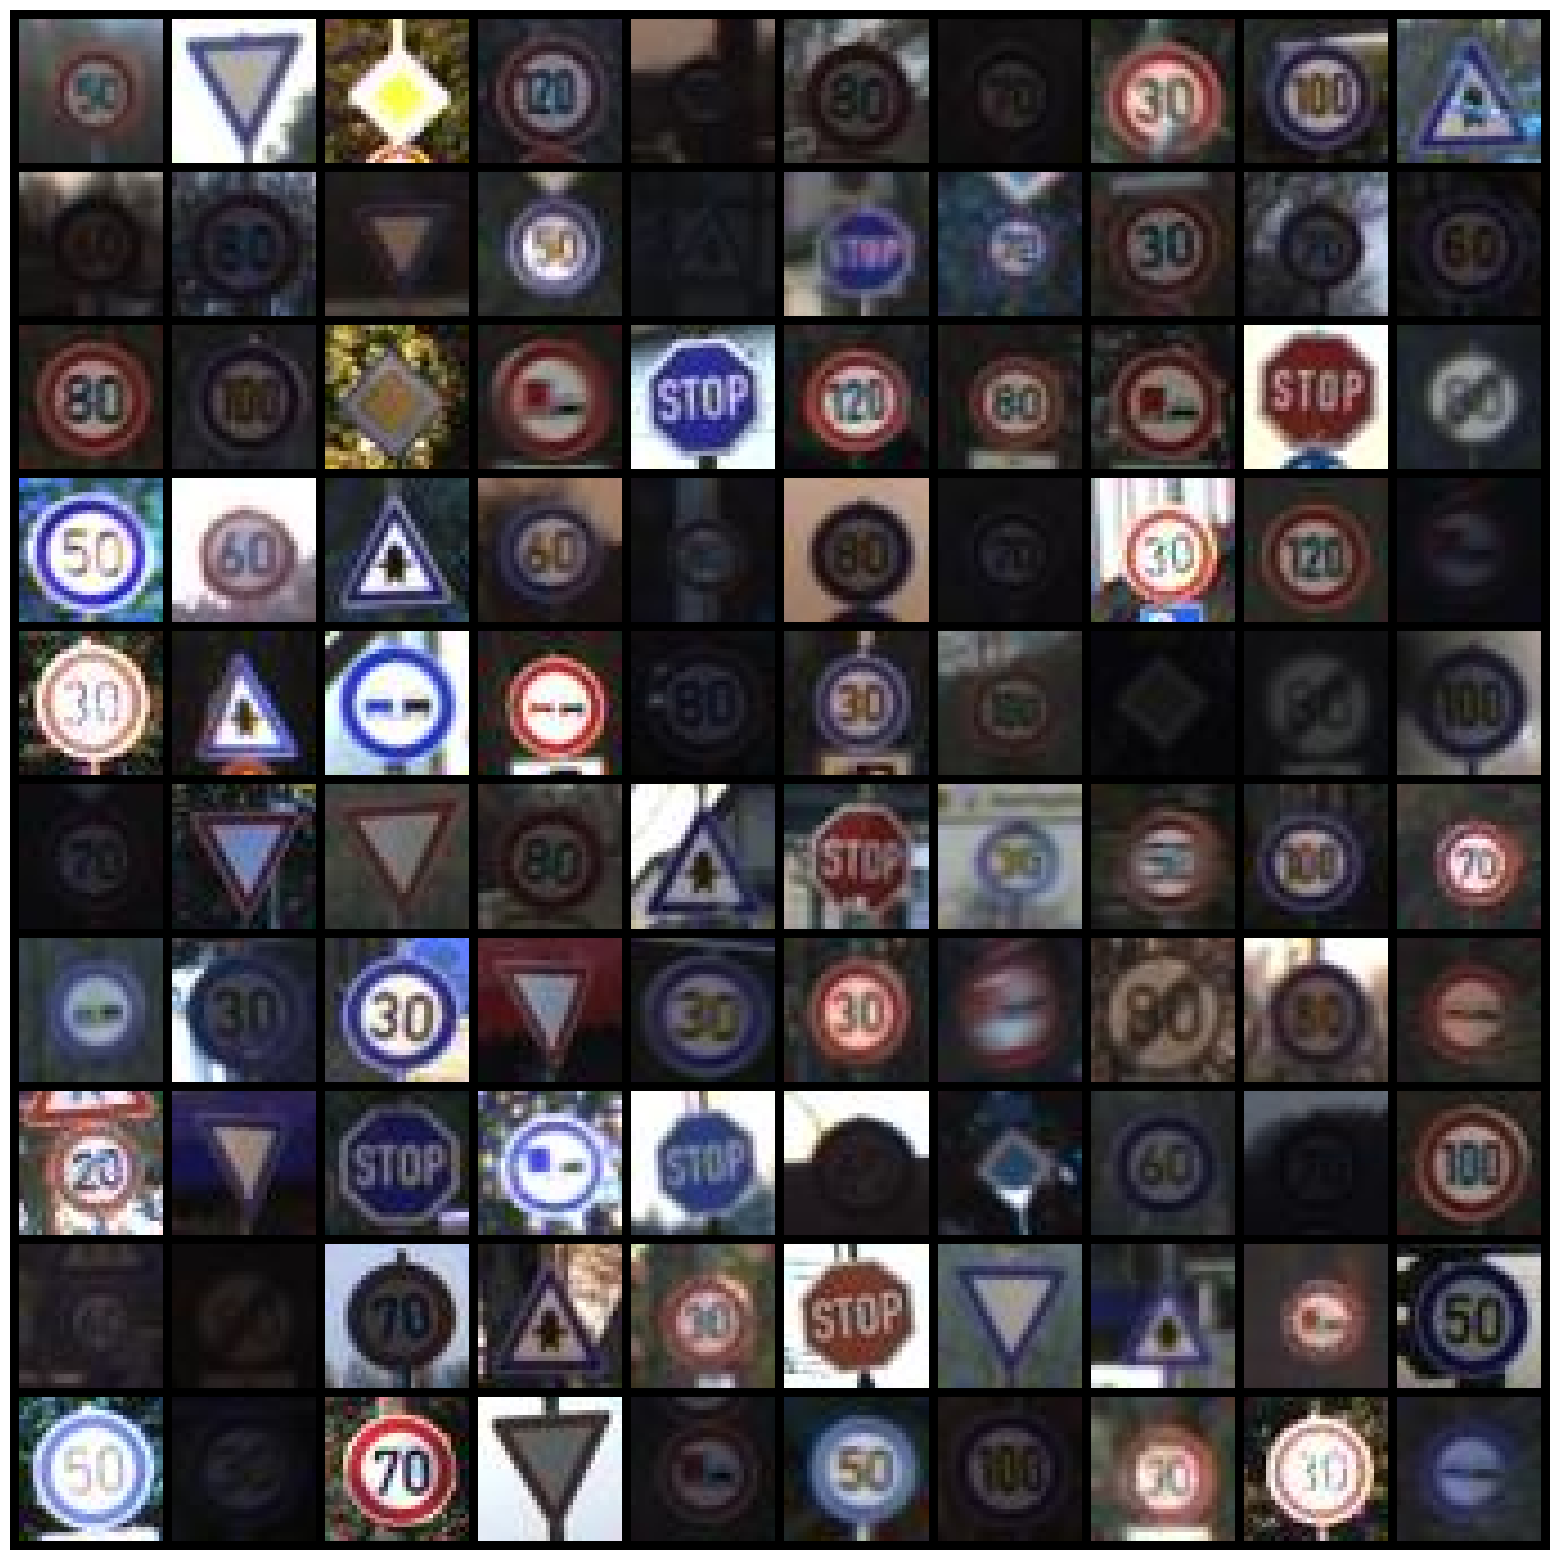



Labels of the above images :

tensor([ 2, 13, 12,  8,  7,  5,  4,  1,  7, 11,  3,  5, 13,  2, 11, 14,  4,  1,
         4,  3,  5,  7, 12, 10, 14,  8,  5, 10, 14,  6,  2,  3, 11,  3,  5,  5,
         4,  1,  8, 10,  1, 11,  9,  9,  5,  1,  7, 12,  6,  7,  4, 13, 13,  5,
        11, 14,  1,  2,  7,  4,  9,  1,  1, 13,  1,  1, 10,  6,  5,  9,  0, 13,
        14, 10, 14,  3, 12,  3,  4,  7,  3,  6,  4, 11,  1, 14, 13, 11, 10,  2,
         2,  1,  4, 13, 10,  2,  7,  1,  1,  9])


In [ ]:
plt.figure(figsize=(20,20))
# make_grid tạo ra một lưới gồm 100 ảnh và hiển thị nó
# Sử dụng tên biến chính xác x_train thay vì xtrain
plt.imshow(tv_utils.make_grid(torch.tensor(X_train[:100]),nrow=10).permute(1,2,0))
plt.axis('off') # Để xóa xticks và yticks
plt.show()
print('\n\nLabels of the above images :\n')
# Sử dụng tên biến chính xác y_train thay vì ytrain
print(y_train[:100])

**Chuyển đổi dữ liệu đào tạo và kiểm tra từ mảng numpy sang tensor để tính toán thêm**

In [ ]:
# Đảm bảo các biến này là numpy arrays trước khi gọi from_numpy
X_train_np = X_train.cpu().numpy() if isinstance(X_train, torch.Tensor) else X_train
y_train_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
X_test_np = X_test.cpu().numpy() if isinstance(X_test, torch.Tensor) else X_test # Sửa lỗi chính tả
y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

xtrain = torch.from_numpy(X_train_np).float()
ytrain = torch.from_numpy(y_train_np).long()
Xtest = torch.from_numpy(X_test_np).float() # Sửa lỗi chính tả
ytest = torch.from_numpy(y_test_np).long()

**Khởi tạo mô hình Neural Network Model**

In [ ]:
import torch
import torch.nn as nn

try:
    from torchsummary import summary as ts_summary
except ImportError:
    print("Warning: torchsummary not found. Model summary will not be available.")
    ts_summary = None # Set to None if not available

model = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=3, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.MaxPool2d(2),

                        nn.Conv2d(32, 64, kernel_size=3, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.MaxPool2d(2),

                        nn.Conv2d(64, 128, kernel_size=3, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.MaxPool2d(2),

                        nn.Flatten(),
                        nn.Linear(128 * 4 * 4, 256),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(256, 43)
                    )

model = model.to(device)

if ts_summary is not None:
    try:
        ts_summary(model, (3,32,32))
    except Exception as e:
        print(f"Error generating model summary: {e}")
        print("Please ensure your input shape (3,32,32) is correct for the model.")
else:
    print("Cannot generate model summary as torchsummary was not found.")

# Tạo một tensor ngẫu nhiên làm đầu vào giả định
dummy_input = torch.randn(1, 3, 32, 32) # Batch size 1, 3 kênh màu, kích thước 32x32

# Chuyển dummy_input sang cùng thiết bị với model
dummy_input = dummy_input.to(device)

# Thực hiện forward pass
try:
    output = model(dummy_input)
    print("\nModel output shape:", output.shape)
except Exception as e:
    print(f"\nError during model forward pass: {e}")
    print("Please check your model architecture and input shape.")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                  [

**Đánh giá mức độ chính xác (accuracy) và mức độ sai số (loss) của mô hình**

In [ ]:
def evaluate(model, data, target, device): # Thêm tham số 'device'
    model.eval() # Đặt mô hình thành chế độ đánh giá
    # Sửa: Sử dụng biến 'device' đã được xác định trước
    data = data.to(device, non_blocking=True)
    target = target.to(device, non_blocking=True)

    length = len(target)
    yhat = model(data) # predict on data
    ypred = yhat.argmax(axis=1) # calculate the prediction labels from yhat
    loss = float(nn.functional.cross_entropy(yhat, target)) # calculate the loss
    acc = float((ypred == target).sum() / length) # Calculate accuracy
    print('Loss :',round(loss,4),'- Accuracy :',round(acc,4)) # Print loss and Accuracy



**In ra mức sai số (loss) và độ chính xác accuracy**

In [ ]:
print('\nInitial Loss and Accuracy on Test Dataset :')
evaluate(model, Xtest.float(), ytest, device)


Initial Loss and Accuracy on Test Dataset :
Loss : 3.7493 - Accuracy : 0.0933


**Huấn luyện mô hình**

In [ ]:
def train_model(model, optimizer_class, epochs=5, batch_size=200, steps_per_epochs=200, max_lr=0.01, grad_clip=0.5, l2_reg=0, device=None, xtrain=None, ytrain=None, xtest=None, ytest=None):
    # Đảm bảo model đã được chuyển đến thiết bị chính xác
    model.to(device)

    hist = [[],[],[],[]] # hist will stores train and test data losses and accuracy of every epochs

    # Kiểm tra xem xtrain, ytrain có được truyền vào không
    if xtrain is None or ytrain is None:
        raise ValueError("xtrain and ytrain must be provided for training.")
    if xtest is None or ytest is None:
        raise ValueError("xtest and ytest must be provided for evaluation.")


    train_ds = [(x,y) for x,y in zip(xtrain,ytrain)] # Prepare training dataset for Data Loader
    training_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True) # Thêm shuffle=True để trộn dữ liệu
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size * steps_per_epochs)
                                    # Data Loader for epoch end evaluation on train data
    del train_ds
    gc.collect() # Delete the used variable and free up memory

    # Initialized the Optimizer to update weights and bias of model parameters
    # Sử dụng optimizer_class được truyền vào
    optimizer = optimizer_class(model.parameters(), weight_decay=l2_reg)

    # Initialized the Schedular to update learning rate as per one cycle policy
    # Đảm bảo steps_per_epoch là số nguyên
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(training_dl))

    # Training Started
    for i in range(epochs):
        print('\nEpoch' , i+1 , ': [',end="")

        # Load Batches of training data loader
        for j,(xb,yb) in enumerate(training_dl):
            # move the training batch data to the correct device memory for faster processing
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            # Calculate Losses and gradients
            yhat = model(xb.float())
            loss = nn.functional.cross_entropy(yhat, yb)
            loss.backward()

            # Clip the outlier like gradients
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # Update Weights and bias
            optimizer.step()
            optimizer.zero_grad()

            # Update Learning Rate
            sched.step()

            del xb,yb,yhat
            if device.type == 'cuda': # Chỉ gọi empty_cache() nếu đang dùng CUDA
                torch.cuda.empty_cache()
            # delete the used data and free up space

            # print the training epochs progress
            if j % int(steps_per_epochs / 20) == 0: # Sửa lỗi chia cho 0 nếu steps_per_epochs quá nhỏ
                print('.',end='')

            # break the loop when all steps of an epoch completed.
            # Cần kiểm tra xem có vượt quá số bước tối đa không, không phải bằng j
            if j >= steps_per_epochs - 1: # -1 vì j bắt đầu từ 0
                break


        # Epochs end evaluation
        print('] ', end='') # Đóng dấu ngoặc vuông cho tiến trình epoch

        for xtrainb,ytrainb in train_dl:
            break

        # move train data to device
        xtrain_data = xtrainb.to(device, non_blocking=True)
        ytrain_data = ytrainb.to(device, non_blocking=True)
        del xtrainb, ytrainb
        gc.collect()
        # delete used variables and free up space

        # Calculate train loss and accuracy
        yhat_train = model(xtrain_data.float())
        ypred_train = yhat_train.argmax(axis=1)
        train_loss = float(nn.functional.cross_entropy(yhat_train, ytrain_data))
        train_acc = float((ypred_train == ytrain_data).sum() / len(ytrain_data))

        del xtrain_data, ytrain_data, yhat_train, ypred_train
        # delete used variables and free up space

        # move test data to device
        xtest_data = xtest.to(device, non_blocking=True)
        ytest_data = ytest.to(device, non_blocking=True)

        # Calculate test loss and accuracy
        yhat_val = model(xtest_data.float())
        ypred_val = yhat_val.argmax(axis=1)
        val_loss = float(nn.functional.cross_entropy(yhat_val, ytest_data))
        val_acc = float((ypred_val == ytest_data).sum() / len(ytest_data))

        del xtest_data, ytest_data, yhat_val, ypred_val

        # print the captured train and test loss and accuracy at the end of every epochs
        print('- Train Loss :',round(train_loss,4),'- Train Accuracy :',round(train_acc,4),
              '- Val Loss :',round(val_loss,4), '- Val Accuracy :',round(val_acc,4))

        # store that data into the previously blank initialized hist list
        hist[0].append(train_loss)
        hist[1].append(val_loss)
        hist[2].append(train_acc)
        hist[3].append(val_acc)

    # Initialized all the evaluation history of all epochs to a dict
    history = {'Train Loss':hist[0],'Val Loss':hist[1],'Train Accuracy':hist[2], 'Val Accuracy':hist[3]}

    # return the history as pandas dataframe
    return pd.DataFrame(history)

In [ ]:
history = train_model(
    model=model,                  # Truyền đối tượng model
    optimizer_class=torch.optim.Adam, # Sử dụng tên tham số mới là optimizer_class
    epochs=25,
    steps_per_epochs=50,
    l2_reg=0,
    max_lr=0.015,
    grad_clip=0.5,
    device=device,                # Truyền biến device vào đây
    xtrain=X_train,                # Truyền dữ liệu huấn luyện
    ytrain=y_train,
    xtest=X_test,                  # Truyền dữ liệu kiểm tra
    ytest=y_test
)


Epoch 1 : [......] - Train Loss : 2.6702 - Train Accuracy : 0.0924 - Val Loss : 2.6656 - Val Accuracy : 0.0933

Epoch 2 : [......] - Train Loss : 2.4862 - Train Accuracy : 0.1753 - Val Loss : 2.5006 - Val Accuracy : 0.1778

Epoch 3 : [......] - Train Loss : 2.4624 - Train Accuracy : 0.171 - Val Loss : 2.4791 - Val Accuracy : 0.1756

Epoch 4 : [......] - Train Loss : 2.3938 - Train Accuracy : 0.1529 - Val Loss : 2.4435 - Val Accuracy : 0.1444

Epoch 5 : [......] - Train Loss : 2.2852 - Train Accuracy : 0.2582 - Val Loss : 2.3687 - Val Accuracy : 0.2178

Epoch 6 : [......] - Train Loss : 2.374 - Train Accuracy : 0.2134 - Val Loss : 2.4049 - Val Accuracy : 0.2044

Epoch 7 : [......] - Train Loss : 2.0769 - Train Accuracy : 0.2997 - Val Loss : 2.169 - Val Accuracy : 0.2667

Epoch 8 : [......] - Train Loss : 1.7482 - Train Accuracy : 0.4073 - Val Loss : 1.8369 - Val Accuracy : 0.3911

Epoch 9 : [......] - Train Loss : 1.3373 - Train Accuracy : 0.5817 - Val Loss : 1.477 - Val Accuracy : 0.5

**Hiển thị hiệu suất mô hình sau khi train**

In [ ]:
history

,Train Loss,Val Loss,Train Accuracy,Val Accuracy
0,2.670201,2.665595,0.092425,0.093333
1,2.486170,2.500614,0.175322,0.177778
2,2.462424,2.479137,0.171034,0.175556
3,2.393764,2.443471,0.152930,0.144444
4,2.285171,2.368728,0.258218,0.217778
5,2.373993,2.404856,0.213435,0.204444
6,2.076864,2.169030,0.299666,0.266667
7,1.748227,1.836853,0.407337,0.391111
8,1.337306,1.476987,0.581706,0.535556
9,1.057541,1.198887,0.629347,0.593333


** theo dõi sự thay đổi của Loss và Accuracy qua từng epoch, nhằm kiểm tra xem mô hình có đang học tốt không (ví dụ: giảm Loss, tăng Accuracy) hay gặp vấn đề như overfitting/underfitting.**



In [ ]:
# used plotly for interactive plotting
fig = px.line(history.iloc[:,:2],title='Loss Per Epochs',labels={'value':'Loss','index':'Epochs'})
fig.update_layout(title={'font_family':'Georgia','font_size':23,'x':0.5}).show()
fig = px.line(history.iloc[:,2:],title='Accuracy Per Epochs',labels={'value':'Accuracy','index':'Epochs'})
fig.update_layout(title={'font_family':'Georgia','font_size':23,'x':0.5}).show()

**Đánh giá hiệu suất mô hình**

In [ ]:
from sklearn.metrics import classification_report
import torch # Ensure torch is imported if not already

# Move xtest to the specified device before making predictions
xtest_on_device =X_test.to(device)

# Now use xtest_on_device for model prediction
ypred = model(xtest_on_device.float()).argmax(axis=1)

# Move the prediction back to CPU for using with scikit-learn classification_report
# which expects numpy arrays or CPU tensors
ypred_cpu = ypred.cpu()

# ytest is already a CPU tensor (based on traceback). If it were on GPU,
# you would need to move it to CPU as well: ytest_cpu = ytest.cpu()

print(classification_report(ytest, ypred_cpu))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.84      0.89      0.86        54
           2       0.76      0.86      0.81        29
           3       0.89      0.81      0.85        31
           4       0.84      0.90      0.87        42
           5       0.79      0.76      0.78        41
           6       0.90      1.00      0.95         9
           7       0.80      0.86      0.83        28
           8       0.73      0.50      0.59        22
           9       0.92      0.92      0.92        24
          10       0.95      0.95      0.95        40
          11       0.96      0.92      0.94        25
          12       0.85      0.95      0.90        42
          13       0.98      0.95      0.96        42
          14       1.00      0.94      0.97        16

    accuracy                           0.87       450
   macro avg       0.88      0.84      0.85       450
weighted avg       0.87   

**Hàm dự đoán ảnh**

In [ ]:
def prediction(img_input): # Đổi tên tham số thành img_input cho rõ ràng hơn
    model.eval()

    # Lưu trữ ảnh gốc để hiển thị sau này (đảm bảo không bị sửa đổi)
    original_pil_img = None
    if isinstance(img_input, str):
        # Mở ảnh từ đường dẫn. Rất quan trọng: .convert('RGB') để đảm bảo ảnh có 3 kênh!
        original_pil_img = PIL.Image.open(img_input).convert('RGB')
        img_tensor_for_model = tv.transforms.ToTensor()(original_pil_img)
    elif isinstance(img_input, PIL.Image.Image):
        # Nếu đầu vào đã là đối tượng PIL Image, chuyển đổi nó sang RGB và sau đó là tensor
        original_pil_img = img_input.convert('RGB')
        img_tensor_for_model = tv.transforms.ToTensor()(original_pil_img)
    elif isinstance(img_input, torch.Tensor):
        # Nếu đầu vào đã là tensor, kiểm tra số kênh
        original_tensor = img_input.cpu() # Đảm bảo ảnh gốc trên CPU nếu cần hiển thị
        if original_tensor.shape[0] == 4: # Nếu là RGBA tensor, cắt bỏ kênh alpha
            img_tensor_for_model = original_tensor[:3, :, :]
        elif original_tensor.shape[0] == 1: # Nếu là ảnh grayscale, chuyển thành 3 kênh bằng cách lặp lại
            img_tensor_for_model = original_tensor.repeat(3, 1, 1)
        else:
            img_tensor_for_model = original_tensor
    else:
        raise ValueError("Input must be a file path (str), a PIL.Image.Image object, or a torch.Tensor.")

    # Resize ảnh để phù hợp với đầu vào của model (32x32)
    # Đối với ảnh đầu vào dạng tensor (C x H x W), torchvision.transforms.Resize là hiệu quả hơn
    resize_transform = tv.transforms.Resize((32, 32))
    img_tensor_for_model = resize_transform(img_tensor_for_model) # img_tensor_for_model là C x H x W

    # Thêm chiều batch (unsqueeze) và chuyển tensor sang đúng thiết bị (GPU/CPU)
    img_tensor_for_model = img_tensor_for_model.unsqueeze(0).to(device)

    # Predict the label
    # Tắt tính toán gradient khi chỉ dự đoán để tiết kiệm bộ nhớ và tăng tốc
    with torch.no_grad():
        pred_logits = model(img_tensor_for_model)
        # Lấy nhãn dự đoán từ output (tensor) và chuyển thành số nguyên Python
        pred = int(pred_logits.argmax(axis=1)[0])

    # Find the traffic sign name for label from labels_df
    try:
        # Lọc DataFrame và lấy giá trị 'Name' đầu tiên.
        # .iloc[0] là cách an toàn để lấy một giá trị từ Series kết quả.
        pred_str = labels_df[labels_df['ClassId'] == pred]['Name'].iloc[0]
    except IndexError:
        # Xử lý trường hợp ClassId không tìm thấy trong labels_df (có thể xảy ra nếu model dự đoán sai ClassId)
        pred_str = f"Unknown Label (ClassId: {pred})"
        print(f"Warning: ClassId {pred} not found in labels_df.")

    # Show the image using matplotlib
    plt.figure(figsize=(5,5))

    # Chuẩn bị ảnh để hiển thị (ảnh gốc, chưa resize về 32x32)
    display_img_np = None
    if original_pil_img: # Nếu ảnh được đọc từ file hoặc là PIL Image
        display_img_np = np.array(original_pil_img) # Chuyển PIL Image sang NumPy array (HxWxC)
    elif isinstance(img_input, torch.Tensor): # Nếu đầu vào là tensor
        # Đảm bảo tensor hiển thị ở CPU và định dạng HxWxC
        temp_tensor_for_display = img_input.permute(1,2,0).cpu().numpy()
        if temp_tensor_for_display.shape[2] == 4: # Nếu có kênh alpha, bỏ đi
            display_img_np = temp_tensor_for_display[:, :, :3]
        elif temp_tensor_for_display.shape[2] == 1: # Nếu grayscale, lặp lại 3 kênh
            display_img_np = np.repeat(temp_tensor_for_display, 3, axis=2)
        else:
            display_img_np = temp_tensor_for_display

    if display_img_np is not None:
        # Resize ảnh hiển thị nếu cần (ví dụ: phóng to lên 1000x1000)
        # Sử dụng interpolation=cv2.INTER_LINEAR để làm mịn ảnh khi phóng to
        display_img_np_resized = cv2.resize(display_img_np, (1000,1000), interpolation=cv2.INTER_LINEAR)
        plt.imshow(display_img_np_resized)
    else:
        print("Could not prepare image for display.")

    plt.axis('off') # Tắt trục tọa độ

    # Print traffic sign that recognized
    print('\nRecognized Traffic Sign :',pred_str,'\n')

    # Trả về kết quả dự đoán (label số nguyên và tên)
    return pred, pred_str

**Kiểm thử**


Recognized Traffic Sign : Speed limit (50km/h) 



(2, 'Speed limit (50km/h)')

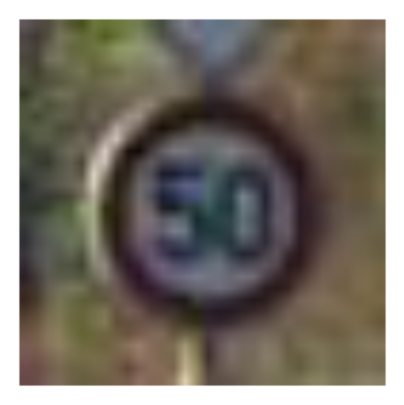

In [ ]:
prediction('/content/drive/MyDrive/dataset/Test final/50km.png')


Recognized Traffic Sign : Stop 



(14, 'Stop')

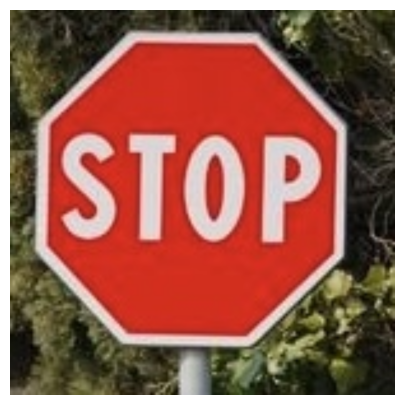

In [ ]:
prediction('/content/drive/MyDrive/dataset/Test final/Stop')
